In [2]:
import pandas as pd

import requests 
from urllib.parse import urlencode 

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import chi2_contingency

import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})

In [3]:
#api to load datasets csv
users_test_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/4XXIME4osGrMRA', sep = ';')

users_control_1_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/yJFydMNNGkEKfg', sep = ';')  

users_control_2_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/br6KkQupzzTGoQ', sep = ';') 

transactions_test_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/gvCWpZ55ODzs2g'\
                                   , sep = ';', parse_dates=['joined_at','paid_at'])

#after first check, found 6 hundreds NaN rows here, so dropping it at the moment of loading csv - .dropna()
transactions_control_1_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/VY5W0keMX5TZBQ'\
                                        , sep = ';', parse_dates=['joined_at','paid_at']).dropna() 

transactions_control_2_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/th5GL0mGOc-qzg'\
                                        , sep = ';', parse_dates=['joined_at','paid_at'])

<h4>First look at datasets</h4>
Basic data validation, and search of potential metrics

In [4]:
users_test_df.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [5]:
#original dataset transactions_control_1_df had 6 hundreds NaN rows - fixed that at csv loading step
transactions_control_1_df.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


<h4>Провожу проверку на наличие дупликатов и валидацию данных</h4>

In [7]:
#To each user dataset adding identificator of sample
users_test_df['group']='test'
users_control_1_df['group']='control1'
users_control_2_df['group']='control2'

In [8]:
#searching for duplicates at each user group separately 
dups_test=users_test_df[users_test_df.duplicated ()].count().sum()

dups_c_1=users_control_1_df[users_control_1_df.duplicated ()].count().sum()

dups_c_2=users_control_2_df[users_control_2_df.duplicated ()].count().sum()

print(dups_test, '\n\n', dups_c_1, '\n\n', dups_c_2)

0 

 0 

 0


In [9]:
#uniting users datasets
users_df=pd.concat([users_test_df, users_control_1_df, users_control_2_df], ignore_index=True)

In [10]:
#searching for duplicates at the all users dataset 
users_df[users_df.duplicated ()].count()

uid                 0
age                 0
attraction_coeff    0
coins               0
country             0
visit_days          0
gender              0
age_filter_start    0
age_filter_end      0
views_count         0
was_premium         0
is_premium          0
total_revenue       0
group               0
dtype: int64

In [11]:
#checking if there is non unique uids
users_df.duplicated (['uid']).sum()

0

In [12]:
users_df.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,test


In [13]:
#to make decision to buy (or not buy) nontrial-premium-subscribtion, user has to visit aplication atlest once
#so im dropping visit_days NaN
users_df=users_df.dropna(subset=['visit_days'])

In [14]:
#To each transaction dataset adding identificator of sample
transactions_test_df['group']='test'
transactions_control_1_df['group']='control1'
transactions_control_2_df['group']='control2'

In [15]:
#unitig transaction data sets
transaction_df=pd.concat([transactions_test_df, transactions_control_1_df, transactions_control_2_df], ignore_index=True)

In [16]:
transaction_df.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test


In [17]:
#searching for duplicates at the all transactions dataset 
transaction_df[transaction_df.duplicated ()].count()

uid             33
country         33
joined_at       33
paid_at         33
revenue         33
payment_id      33
from_page       33
product_type    33
group           33
dtype: int64

In [18]:
#have found duplicates, dropping
transaction_df.drop_duplicates()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test
...,...,...,...,...,...,...,...,...,...
973,891985866.0,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640.0,147.0,trial_vip_popup,trial_premium,control2
974,891491145.0,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727.0,147.0,send_message,trial_premium,control2
975,892053750.0,United States of America,2017-10-22 00:46:00,2017-10-28 08:17:00,1261.0,19.0,autorefill,coins,control2
976,891668253.0,Chile,2017-10-29 23:08:00,2017-11-15 00:57:00,9997.0,147.0,trial_vip_popup,trial_premium,control2


In [19]:
#test group changes been made only for nontrial-premium subscription
transaction_premium_df=transaction_df.query('product_type=="premium_no_trial"')
transaction_premium_df.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
5,892426491.0,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597.0,147.0,autoreply_message,premium_no_trial,test
6,891558921.0,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100.0,147.0,left_sidebar_menu,premium_no_trial,test
11,891861048.0,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588.0,68.0,none,premium_no_trial,test
12,891178380.0,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,test
21,891312873.0,Italy,2017-05-11 21:22:00,2017-10-11 21:51:00,7852.0,147.0,promo_09,premium_no_trial,test


In [18]:
#test group changes been made only for two payment systems, checking which of payment_id it is
transaction_premium_df.payment_id.value_counts()

147.0    243
68.0      42
0.0        4
Name: payment_id, dtype: int64

In [19]:
#two payment systems had been changed, there is three in data.. considering, we are working with p_id 147 and 68
transaction_premium_df=transaction_premium_df.query('payment_id!=0.0')
transaction_premium_df.payment_id.value_counts()

147.0    243
68.0      42
Name: payment_id, dtype: int64

In [20]:
#time logic chek - date of registration before or equial to payment date
transaction_premium_df.query('joined_at>paid_at').head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
11,891861048.0,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588.0,68.0,none,premium_no_trial,test
38,892065108.0,France,2017-10-21 20:40:00,2017-08-11 22:45:00,7098.0,147.0,popular_users_chat,premium_no_trial,test
56,892261437.0,Italy,2017-10-17 14:22:00,2017-06-11 11:51:00,1898.0,68.0,none,premium_no_trial,test
74,892205850.0,Spain,2017-10-18 19:20:00,2017-02-11 00:13:00,5408.0,147.0,promo_09,premium_no_trial,test
84,891861489.0,Australia,2017-10-26 02:31:00,2017-04-11 02:04:00,12597.0,147.0,promo_09,premium_no_trial,test


In [21]:
#there is payments before registration - dropping
transaction_premium_df=transaction_premium_df.query('joined_at<=paid_at')
transaction_premium_df.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
5,892426491.0,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597.0,147.0,autoreply_message,premium_no_trial,test
6,891558921.0,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100.0,147.0,left_sidebar_menu,premium_no_trial,test
12,891178380.0,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,test
21,891312873.0,Italy,2017-05-11 21:22:00,2017-10-11 21:51:00,7852.0,147.0,promo_09,premium_no_trial,test
22,891071157.0,United States of America,2017-10-11 10:20:00,2017-10-11 16:37:00,9100.0,147.0,promo_09,premium_no_trial,test


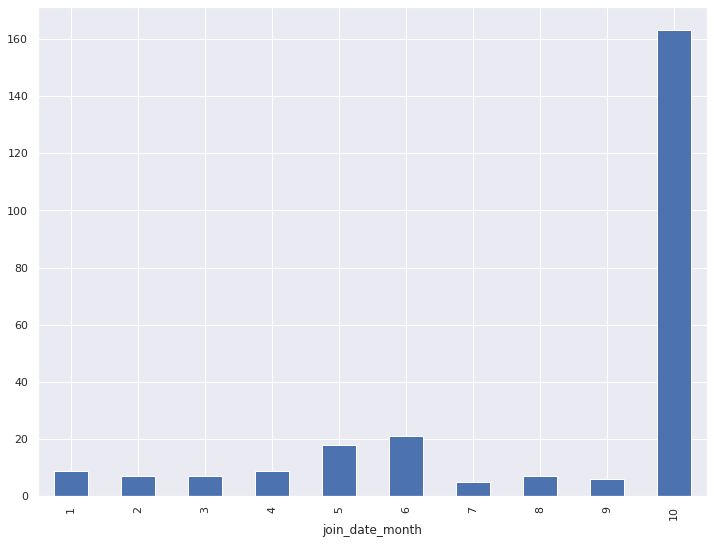

In [22]:
#chenges have been apllied only to new users. Trying to get who is new.. grouping by registration date
transaction_premium_df_jd=transaction_premium_df
transaction_premium_df_jd['join_date_month']=transaction_premium_df['joined_at'].dt.month
transaction_premium_df_jd[['join_date_month','uid']].groupby('join_date_month')\
    .count().plot(kind='bar', legend=None)

In [23]:
#copying users_df to work with visit_days. Note - NaN visit_days had been dropped before

users_df_vdc=users_df
users_df_vdc['visit_days_count']=users_df_vdc['visit_days'].apply(lambda x: len(x.split(',')))
users_df_vdc=users_df_vdc.sort_values('visit_days_count', ascending=False)
users_df_vdc.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_days_count
3418,892437846,30,829,NaN,Canada,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,27,33,82,NaN,NaN,0,test,31
8703,892425369,18,289,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,15,21,107,NaN,NaN,0,control2,31
10672,892385832,22,373,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",0,19,25,4762,NaN,NaN,0,control2,31
4487,892337712,49,677,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,31,41,493,NaN,NaN,0,control1,31
10521,892437816,18,159,NaN,Argentina,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,23,88,NaN,NaN,0,control2,31


In [24]:
#choosing users with most count of visit days, at the same time grouping by count and exact days list

longest_visit_streak_group=users_df_vdc.query('visit_days_count==31')\
    .groupby(['visit_days','visit_days_count'], as_index=False)\
    .agg(users=('uid','count'))
longest_visit_streak_group

,visit_days,visit_days_count,users
0,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",31,19


In [25]:
#lets look the last visit day
longest_visit_streak_group.visit_days.loc[0]

'1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,60'

In [26]:
#as far as most of all transactions made in lat month, and last visit day is 60..
#considering new users - is users with registration date in the last two month - october, september
#to transaction dataset addind identificator, to be able drop old users after uniting transaction and users data sets 
transaction_premium_df['not_new_user']=np.where(transaction_premium_df['joined_at'] < '2017-09-01', 1, np.nan)
transaction_premium_df.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,join_date_month,not_new_user
5,892426491.0,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597.0,147.0,autoreply_message,premium_no_trial,test,10,NaN
6,891558921.0,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100.0,147.0,left_sidebar_menu,premium_no_trial,test,1,1.0
12,891178380.0,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,test,8,1.0
21,891312873.0,Italy,2017-05-11 21:22:00,2017-10-11 21:51:00,7852.0,147.0,promo_09,premium_no_trial,test,5,1.0
22,891071157.0,United States of America,2017-10-11 10:20:00,2017-10-11 16:37:00,9100.0,147.0,promo_09,premium_no_trial,test,10,NaN


In [27]:
#we knw that the experment had been ran for 'several' countries, so im gonna check if ther is different countries in samples  
#and if there is, will keep only countries that met at each sample
countries_pivot=pd.pivot_table(users_df, index = 'country', columns = 'group', values = 'uid', aggfunc='count')
countries_pivot

group,control1,control2,test
country,,,
Algeria,2.0,NaN,2.0
Argentina,265.0,261.0,283.0
Armenia,1.0,NaN,NaN
Australia,35.0,31.0,38.0
Austria,NaN,1.0,NaN
...,...,...,...
United Kingdom (Great Britain),100.0,107.0,120.0
United States of America,966.0,962.0,958.0
Uruguay,NaN,1.0,NaN


In [28]:
#dropping countries that not met at each group sample
countries_pivot.dropna()

group,control1,control2,test
country,,,
Argentina,265.0,261.0,283.0
Australia,35.0,31.0,38.0
Belgium,76.0,67.0,63.0
Canada,90.0,98.0,104.0
Chile,215.0,202.0,179.0
Colombia,1.0,2.0,1.0
Costa Rica,1.0,1.0,1.0
Dominican Republic,1.0,1.0,1.0
France,276.0,254.0,245.0


In [29]:
#merging users_df and transaction_df
transaction_premium_grouped=transaction_premium_df.groupby('uid', as_index=False)\
    .agg(prem_nontrial_revenue_sum=('revenue','sum'),
        not_new_user=('not_new_user', 'max'))

merged_df=users_df.merge(transaction_premium_grouped, how='left', on='uid')
merged_df.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_days_count,prem_nontrial_revenue_sum,not_new_user
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test,14,NaN,NaN
1,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test,20,NaN,NaN
2,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test,12,NaN,NaN
3,891083133,24,0,NaN,Spain,1,1,16,27,0,NaN,NaN,0,test,1,NaN,NaN
4,891085770,28,0,NaN,Italy,"1,2,3,4",1,25,31,1,NaN,NaN,0,test,4,NaN,NaN


In [30]:
#filtering merged dataframe by criterias - new user and country
merged_df=merged_df.query('not_new_user!=1')

shared_countries_list=countries_pivot.index.values.tolist()
merged_df=merged_df.query('country==@shared_countries_list')
merged_df.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_days_count,prem_nontrial_revenue_sum,not_new_user
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test,14,NaN,NaN
1,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test,20,NaN,NaN
2,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test,12,NaN,NaN
3,891083133,24,0,NaN,Spain,1,1,16,27,0,NaN,NaN,0,test,1,NaN,NaN
4,891085770,28,0,NaN,Italy,"1,2,3,4",1,25,31,1,NaN,NaN,0,test,4,NaN,NaN


<h4>Data validation conclusion:</h4>
Datasets cleaned from duplicates and NaNs<br>
Dropped users that did not visit application<br>
As target action - transactions filtered with only nontrial-premium subscription<br>
As new useres choosen people who have registred in last two month (61 day)<br>
Countries filtered based on the fa that it must be represented at each group sample<br>

<h4>Next going to check representativeness of group samples</h4>
To do so lets see deffusion between group samples by age, gender, country of users

In [31]:
#adding ae groups
merged_df['age_group']=pd.cut(
                            merged_df['age'],
                            [17, 25, 35, 50, 100],
                            labels=['18-25 years old', '26-35 years old', '36-50 years old', '50+']
                            )
merged_df.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_days_count,prem_nontrial_revenue_sum,not_new_user,age_group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test,14,NaN,NaN,26-35 years old
1,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test,20,NaN,NaN,36-50 years old
2,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test,12,NaN,NaN,26-35 years old
3,891083133,24,0,NaN,Spain,1,1,16,27,0,NaN,NaN,0,test,1,NaN,NaN,18-25 years old
4,891085770,28,0,NaN,Italy,"1,2,3,4",1,25,31,1,NaN,NaN,0,test,4,NaN,NaN,26-35 years old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8889,891094593,55,222,NaN,United States of America,"1,2,3,4,5,6",1,28,38,117,NaN,NaN,0,control2,6,NaN,NaN,50+
8890,891095106,22,625,NaN,United Arab Emirates,"1,2,3,4,5",1,19,25,8,NaN,NaN,0,control2,5,NaN,NaN,18-25 years old
8891,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,NaN,NaN,0,control2,2,NaN,NaN,50+
8892,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,NaN,NaN,0,control2,13,NaN,NaN,26-35 years old


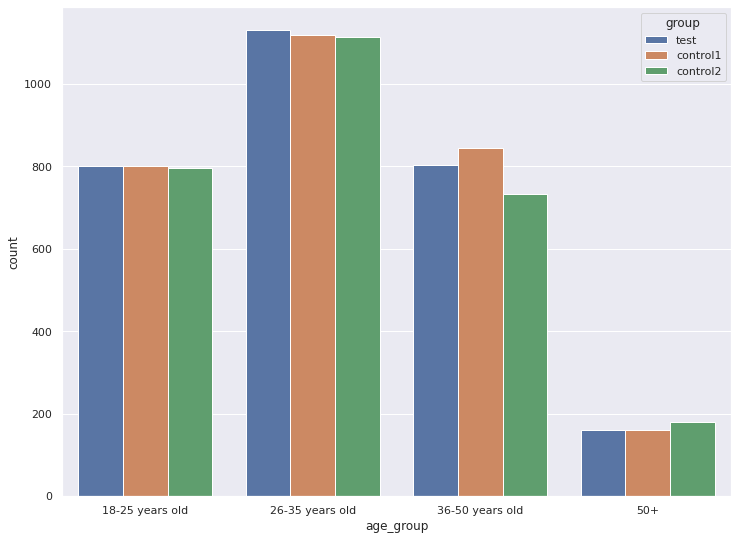

In [32]:
#age group barchart
sns.countplot(x ='age_group', hue = "group", data = merged_df)

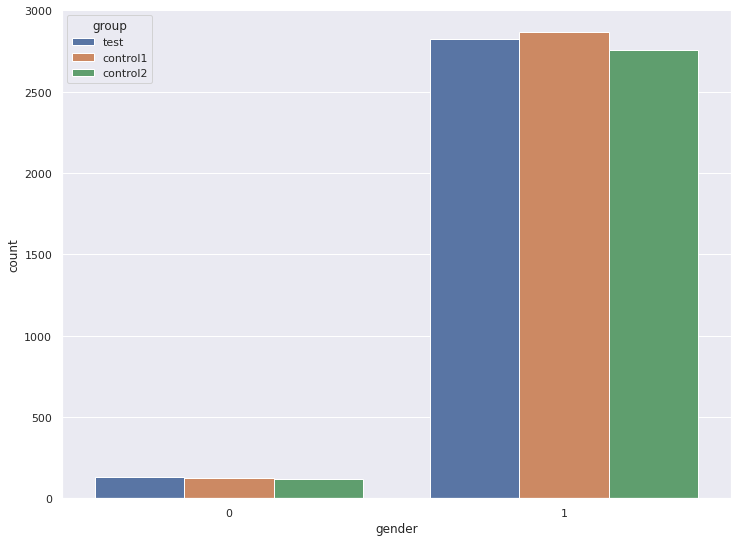

In [33]:
#gender barchart
sns.countplot(x ='gender', hue = "group", data = merged_df)

In [34]:
#For better visualisation gonna take only top 10 countries by number of users
top_10_countries_list=merged_df.groupby('country', as_index=False)\
    .agg({'uid':'count'})\
    .sort_values('uid', ascending=False).country[:9].tolist()
top_10_countries_list

['United States of America',
 'Argentina',
 'France',
 'Italy',
 'Spain',
 'Chile',
 'United Arab Emirates',
 'Germany',
 'United Kingdom (Great Britain)']

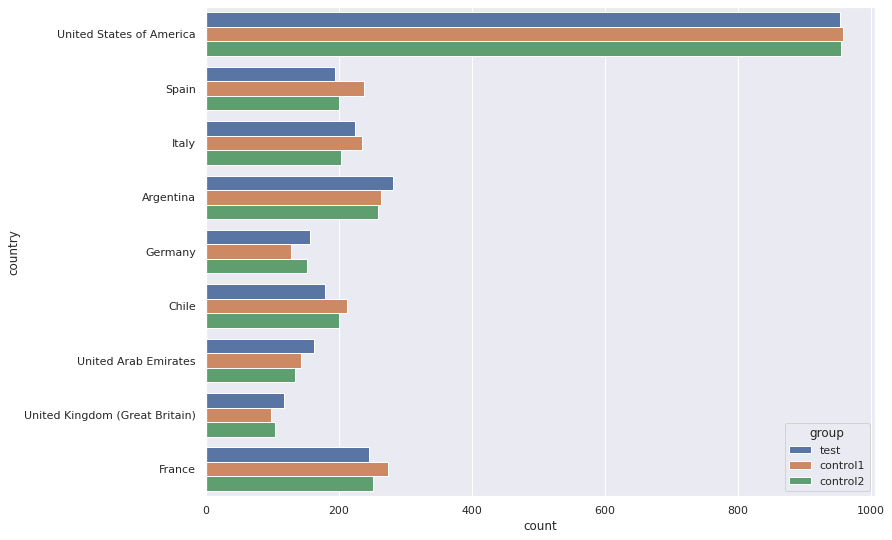

In [35]:
#top 10 countries users distribution barchart
top_10_countries_df=merged_df.query('country==@top_10_countries_list')
sns.countplot(y ='country', hue = "group", data = top_10_countries_df)

<h4>By choosen criterias - age, gender, country - group samples are representative</h4>

<h4>Time to define metrics to compare group samples:</h4>
As far as the only change is nontrial-premium sub price, im expecting to see statistically significant differences in test group  with mectrics - conversion and revenue from nontrial-premiun subscribtion

In [37]:
#counting conversion for each group sample
test_total_u=merged_df.query('group=="test"').count()[0]
test_paying_u=merged_df.query('group=="test"').count()['prem_nontrial_revenue_sum']

test_conversion=test_paying_u/test_total_u

control1_total_u=merged_df.query('group=="control1"').count()[0]
control1_paying_u=merged_df.query('group=="control1"').count()['prem_nontrial_revenue_sum']

control1_conversion=control1_paying_u/control1_total_u

control2_total_u=merged_df.query('group=="control2"').count()[0]
control2_paying_u=merged_df.query('group=="control2"').count()['prem_nontrial_revenue_sum']

control2_conversion=control2_paying_u/control2_total_u

print('Conversion by group', '\n',\
      'testing: ', test_conversion, '\n','cgroup1: ', control1_conversion, '\n', 'cgroup2 ', control2_conversion)

Conversion by group 
 testing:  0.012508451656524679 
 cgroup1:  0.018747907599598258 
 cgroup2  0.02017391304347826


In [38]:
#conducting chi-square test, first of all - А1А2, to be sure that control groups have no difference
chi2_contingency([[control1_paying_u, control1_total_u-control1_paying_u],\
                  [control2_paying_u, control2_total_u-control2_paying_u]])[1]

0.7636828691614241

p-value more than 0.05 - which means there is no statistically significant differences between control groups 1 and 2

In [39]:
#conducting chi-square tests with test group - А1В, А2В
A1B=chi2_contingency([[control1_paying_u, control1_total_u-control1_paying_u],\
                  [test_paying_u, test_total_u-test_paying_u]])[1]

A2B=chi2_contingency([[control2_paying_u, control2_total_u-control2_paying_u],\
                  [test_paying_u, test_total_u-test_paying_u]])[1]

print('A1B:', A1B, '\n','A2B: ', A2B)

A1B: 0.06666984903301655 
 A2B:  0.0271794209597311


chi-square tests shows statistically significant differences only between second control and test groups (p-value < 0.05)

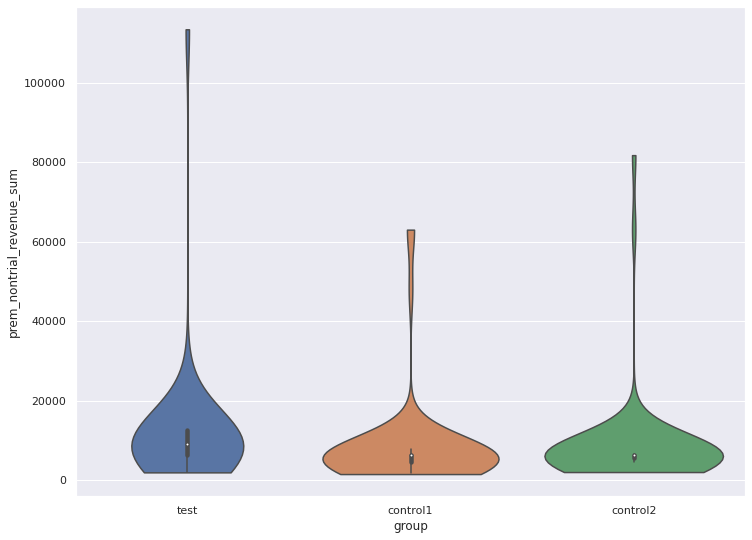

In [40]:
#to define statistical test for revenue distribution first lets look at it
sns.violinplot(x = 'group', y = 'prem_nontrial_revenue_sum', data = merged_df, cut=0)

All revenue is log-normal, with long pisitive tails. That kind of tail means small number of subscribers (customers) who pay way more than others.<br>Such distribution is typical for subscription services and e-comemrce businesses<br><br>
To compare revenue from nontrial-premium subscriptions going to use t-test, cuz samples are independent, continuous, and with samples of that size there is no need for distribution to be normal-like to conduct t-test.

In [41]:
#t-test control groups А1А2
stats. ttest_ind (a=merged_df.query('group=="control1"').prem_nontrial_revenue_sum.dropna(),\
                  b=merged_df.query('group=="control2"').prem_nontrial_revenue_sum.dropna())

Ttest_indResult(statistic=-0.09901792294611941, pvalue=0.9213010466355135)

In [42]:
#t-test with test group А1В and А2В
A1B=stats. ttest_ind (a=merged_df.query('group=="test"').prem_nontrial_revenue_sum.dropna(), \
                  b=merged_df.query('group=="control1"').prem_nontrial_revenue_sum.dropna())[1]
A2B=stats. ttest_ind (a=merged_df.query('group=="test"').prem_nontrial_revenue_sum.dropna(), \
                  b=merged_df.query('group=="control2"').prem_nontrial_revenue_sum.dropna())[1]

print('t-tests', '\n', 'A1B pvalue: ', A1B, '\n', 'A2B pvalue:', A2B)

t-tests 
 A1B pvalue:  0.269741217282774 
 A2B pvalue: 0.3023028873992655


p-value more than 0.05 in every case - so there is no statistically significant differences in test group compare to both control groups 

<h4>Conclusion:</h4>
Based on conversion chi-square tests there is statistically significant differences only between second control and test groups. This test also shows no difference between both control groups.<br>T-test for revenue distribution from nontrial-premiun subscribtions shows no statistically significant differences inbetween all of group samples, nither both control groups, or test compare to control groups.<br><br>


Important to note that the only significant difference, that we manage to detect(conversion chi-square test), shows us that in test group conversion dropped down significantly compare to control group 2. That means in test group conversion rate is worse than in control group 2, which is not the effect that expected from payment system improvment.<br><br>


Based on current data we can conclued that experiment is unsuccessful. There is not sigh of any profit from new price policy for nontrial-premium subscribtion. This changes does not increase revenue. More than that, there are evidence that it could decrease conversion rate.
To sum up - experimental price policy, with its current configuration, should not become main for the aplication.